# DeepQLearning

## INITIALIZATION: libraries, parameters, network...

In [1]:
import numpy as np
from collections import deque            # For storing moves 

import gym                                # To train our network
env = gym.make('MountainCar-v0')          # Choose game (any in the gym should work)

import random     # For sampling batches from the observations

import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

[2017-08-12 17:49:55,885] Making new env: MountainCar-v0


## Util functions

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
    
####NEURAL NETWORK MODEL#####
    
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)

    return 1/(1+np.exp(-x))

def train(X,y,syn0,syn1,num_steps):
    for j in range(num_steps):

        # Feed forward through layers 0, 1, and 2
        l0 = X
        l0_flatten = X.flatten()
        
        l1 = nonlin(np.dot(l0_flatten,syn0))
        l2 = nonlin(np.dot(l1,syn1))

        # how much did we miss the target value?
        l2_error = y - l2

        # in what direction is the target value?
        # were we really sure? if so, don't change too much.
        l2_delta = l2_error*nonlin(l2,deriv=True)

        # how much did each l1 value contribute to the l2 error (according to the weights)?
        l1_error = l2_delta.dot(syn1.T)

        # in what direction is the target l1?
        # were we really sure? if so, don't change too much.
        l1_delta = l1_error * nonlin(l1,deriv=True)
        
        return syn0,syn1
    
def predict(X,syn0,syn1):
    l0 = X.flatten()
    l1 = nonlin(np.dot(l0,syn0))
    l2 = nonlin(np.dot(l1,syn1))

    return l2

## Create model 
Input is two consecutive game states, output is Q-values of the possible moves.

In [3]:
# Flatten input so as to have no problems with processing
layer1 = np.random.random((4,20)) - 1
layer2 = np.random.random((20,3)) - 1

In [4]:
# Parameters
D = deque()                                # Register where the actions will be stored

observetime = 500                          # Number of timesteps we will be acting on the game and observing results
epsilon = 0.7                              # Probability of doing a random move
gamma = 0.9                                # Discounted future reward. How much we care about steps further in time
mb_size = 50                               # Learning minibatch size

## FIRST STEP: Knowing what each action does (Observing)

In [5]:
observation = env.reset()                     # Game begins
obs = np.expand_dims(observation, axis=0)     # (Formatting issues) Making the observation the first element of a batch of inputs 
state = np.stack((obs, obs), axis=1)
done = False

for t in range(observetime):
    if np.random.rand() <= epsilon:
        action = np.random.randint(0, env.action_space.n, size=1)[0]
    else:
        Q = predict(state,layer1,layer2)          # Q-values predictions
        action = np.argmax(Q)             # Move with highest Q-value is the chosen one
    observation_new, reward, done, info = env.step(action)     # See state of the game, reward... after performing the action
    obs_new = np.expand_dims(observation_new, axis=0)          # (Formatting issues)
    state_new = np.append(np.expand_dims(obs_new, axis=0), state[:, :1, :], axis=1)     # Update the input with the new state of the game
    D.append((state, action, reward, state_new, done))         # 'Remember' action and consequence
    state = state_new         # Update state
    if done:
        env.reset()           # Restart game if it's finished
        obs = np.expand_dims(observation, axis=0)     # (Formatting issues) Making the observation the first element of a batch of inputs 
        state = np.stack((obs, obs), axis=1)
print('Observing Finished')

Observing Finished


## SECOND STEP: Learning from the observations (Experience replay)

In [6]:
minibatch = random.sample(D, mb_size)                              # Sample some moves

inputs_shape = (mb_size,) + state.shape[1:]
inputs = np.zeros(inputs_shape)
targets = np.zeros((mb_size, env.action_space.n))

for i in range(0, mb_size):
    state = minibatch[i][0]
    action = minibatch[i][1]
    reward = minibatch[i][2]
    state_new = minibatch[i][3]
    done = minibatch[i][4]
    
# Build Bellman equation for the Q function
    inputs[i:i+1] = np.expand_dims(state, axis=0)
    targets[i] = predict(state_new,layer1,layer2)
    Q_sa = predict(state_new,layer1,layer2)
    
    if done:
        targets[i, action] = reward
    else:
        targets[i, action] = reward + gamma * np.max(Q_sa)

# Train network to output the Q function
    for inp,target in zip(inputs,targets):
        layer1,layer2 = train(inp,target,layer1,layer2,1000)
print('Learning Finished')

Learning Finished


## THIRD STEP: Play!

Game ended! Total reward: -200.000000



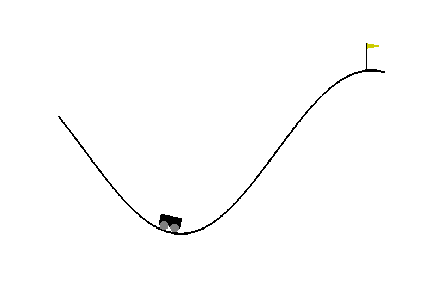
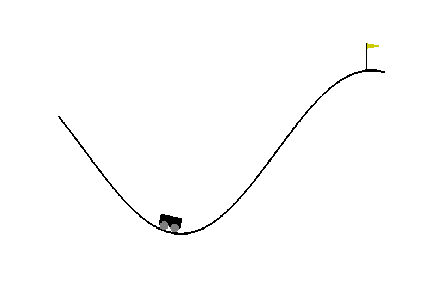
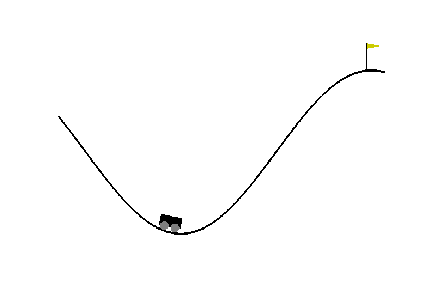
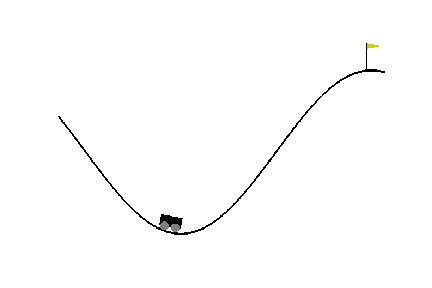
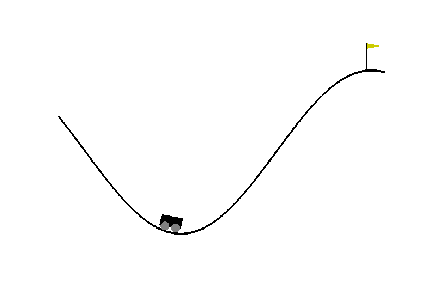
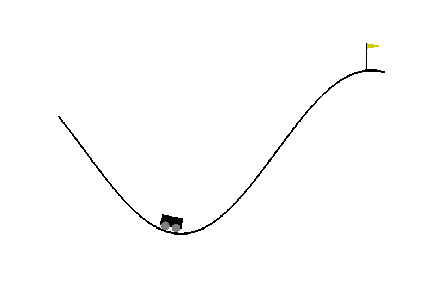
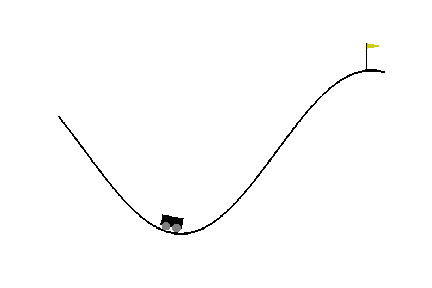
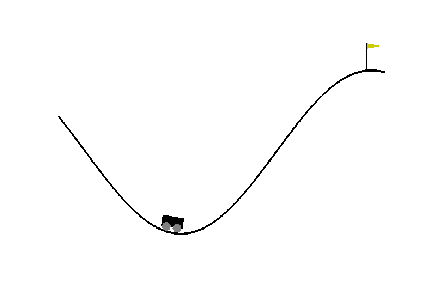
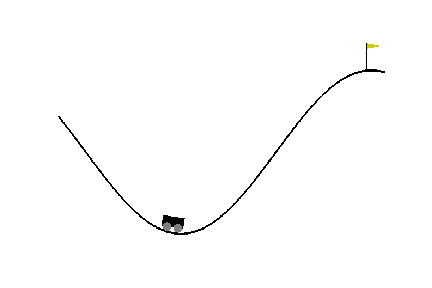
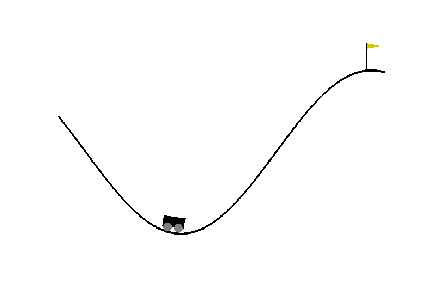
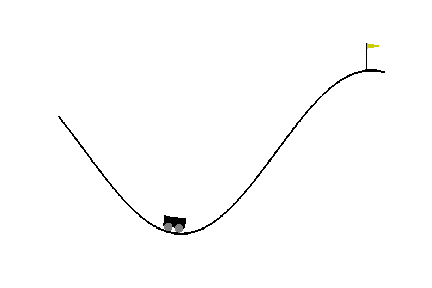
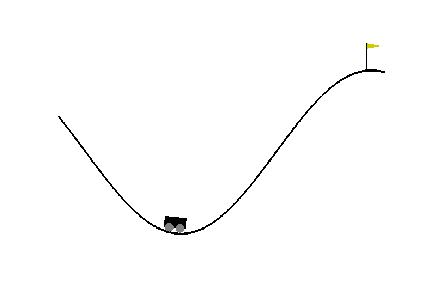
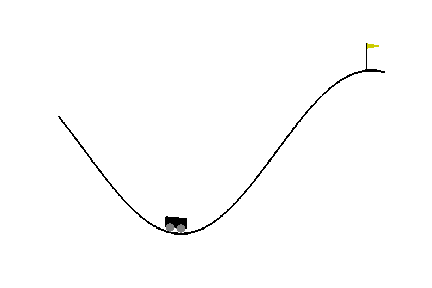
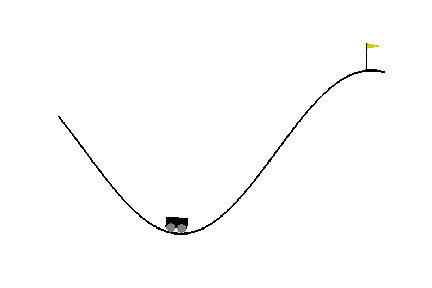
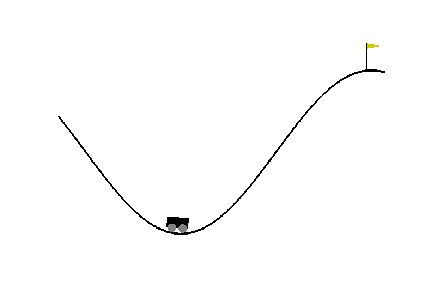
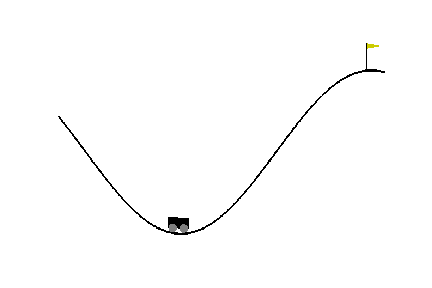
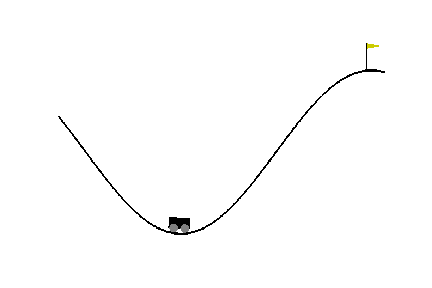
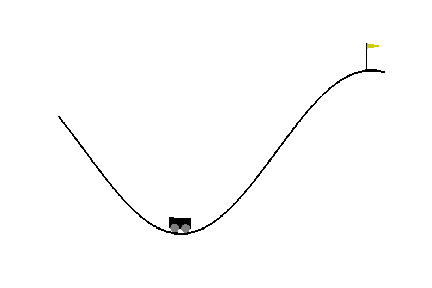
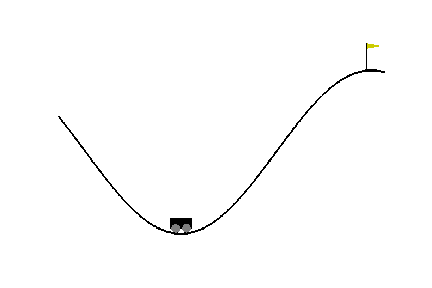
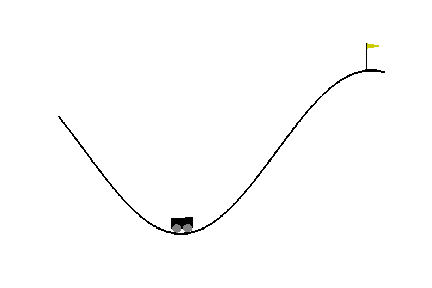
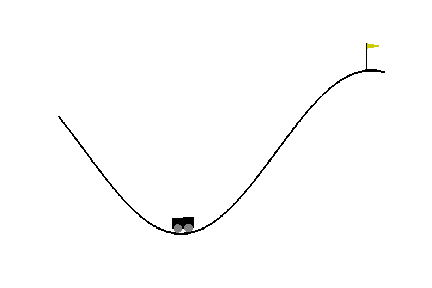
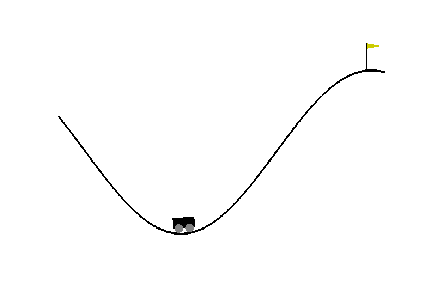
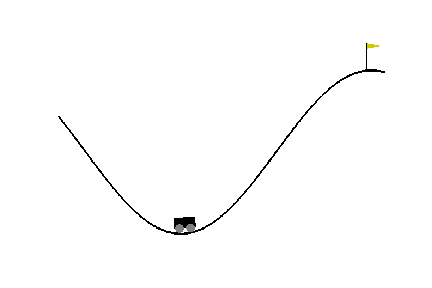
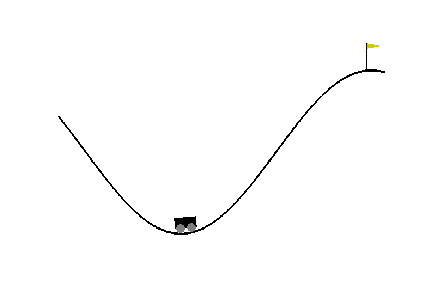
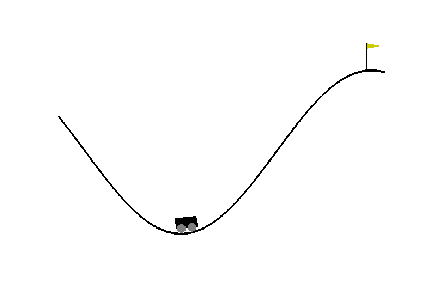
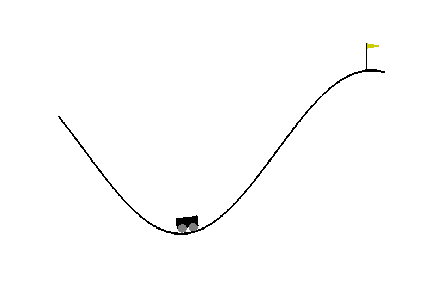
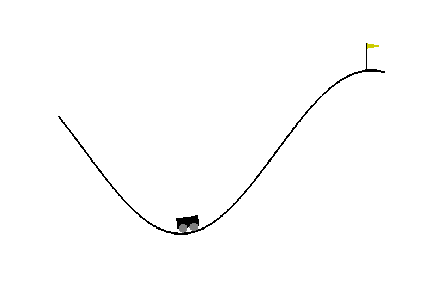
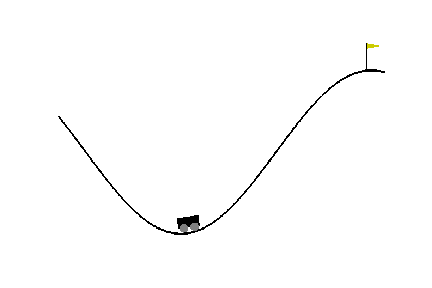
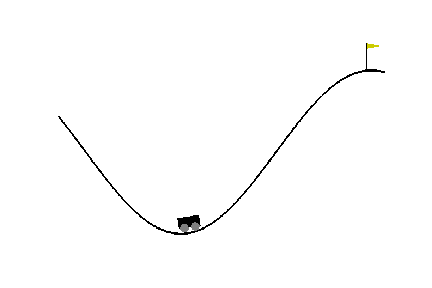
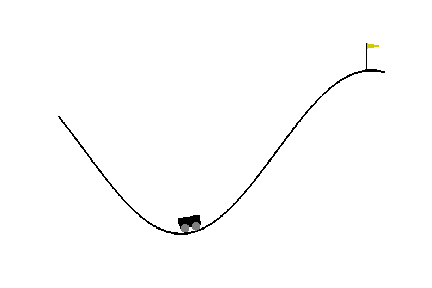
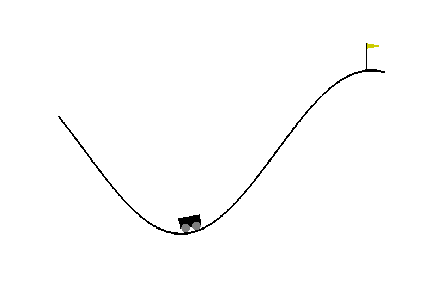
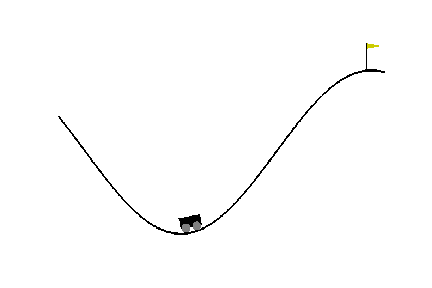
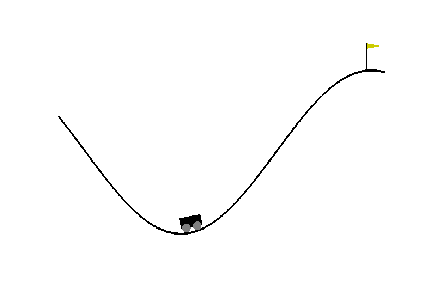
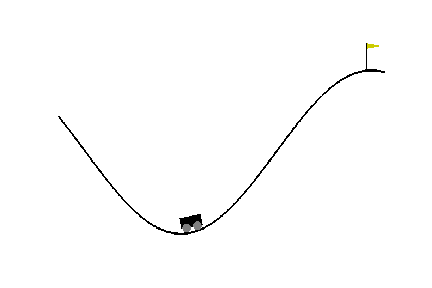
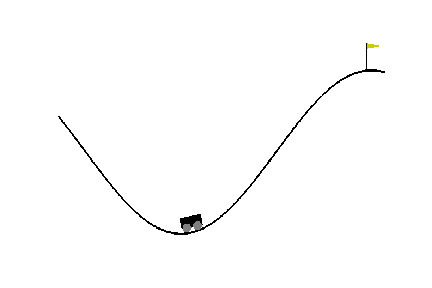
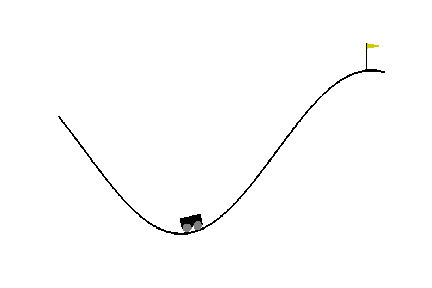
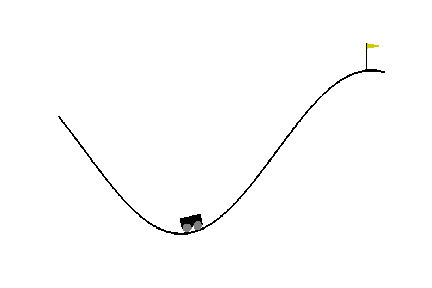
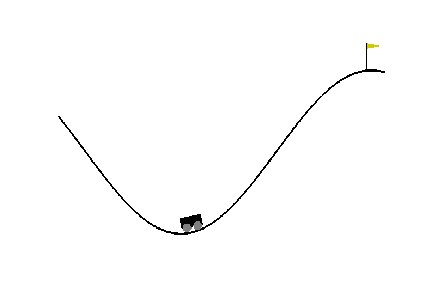
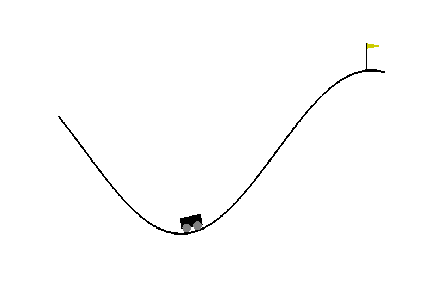
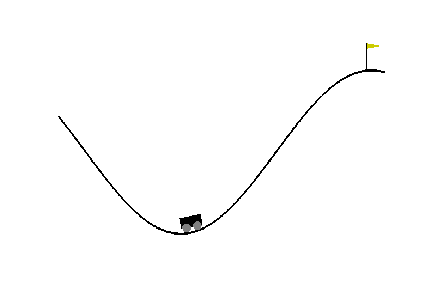
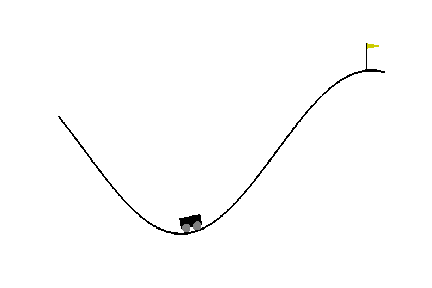
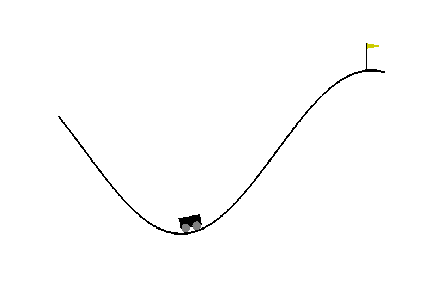
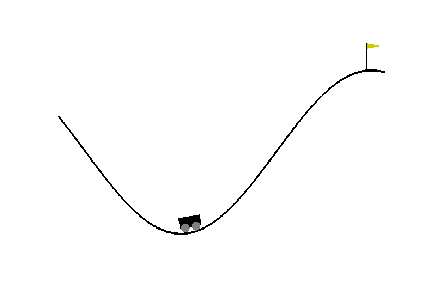
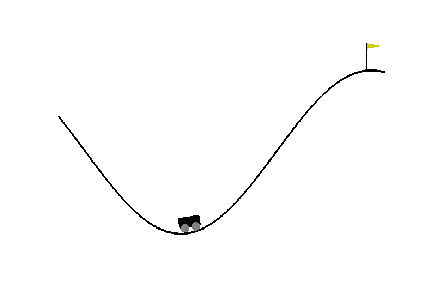
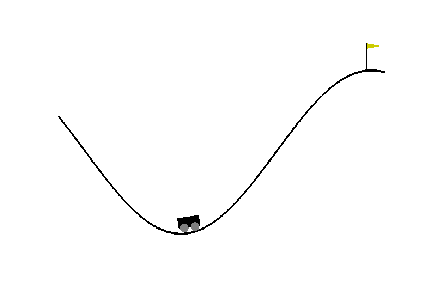
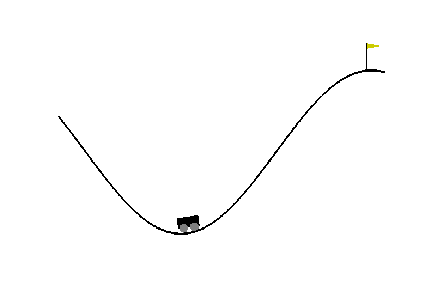
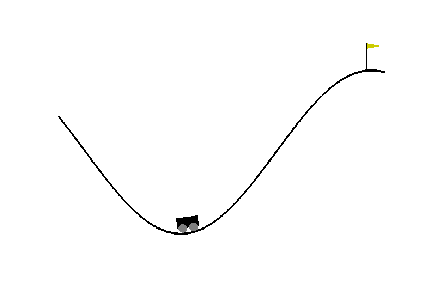
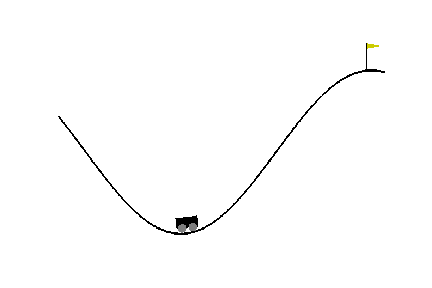
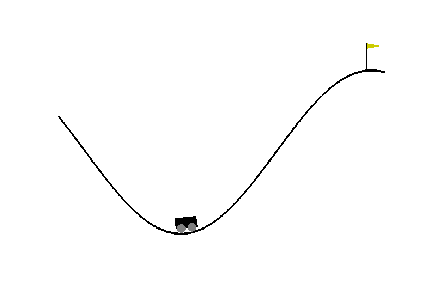
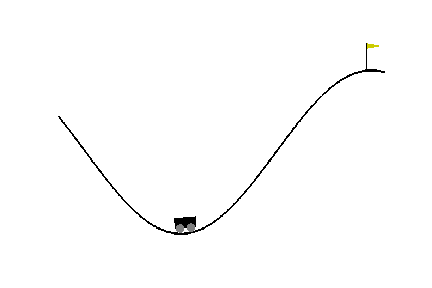
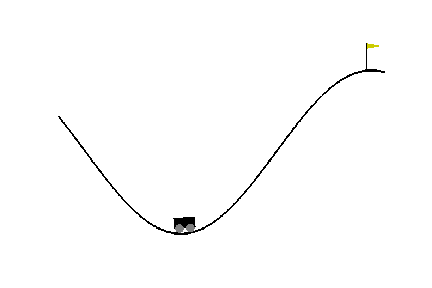
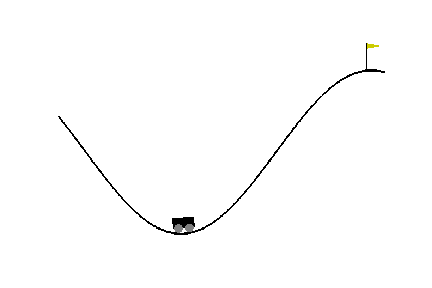
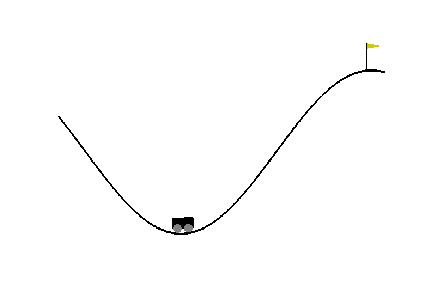
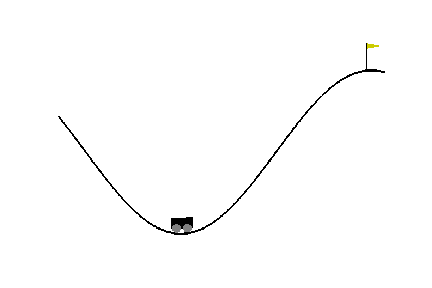
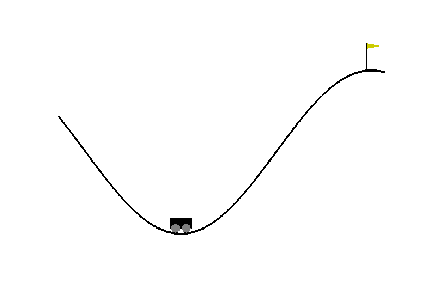
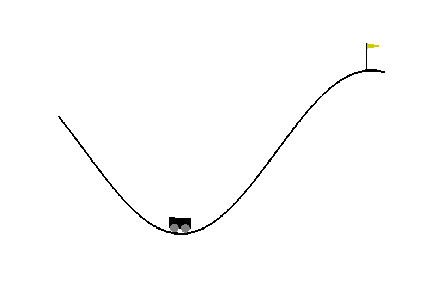
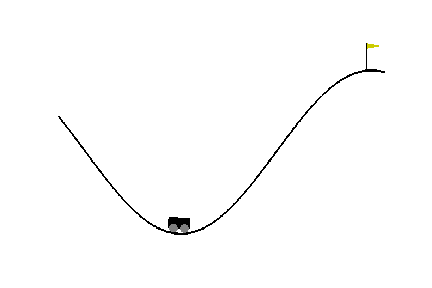
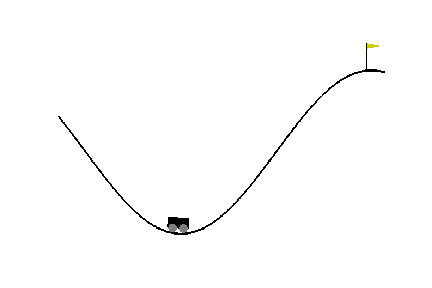
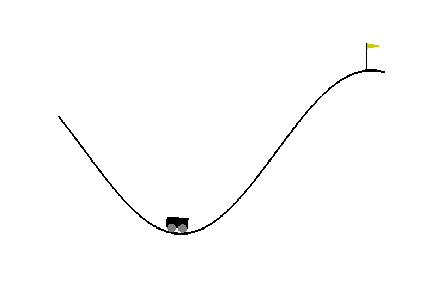
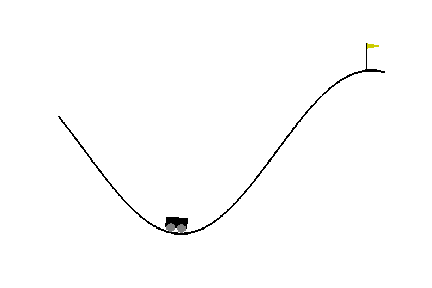
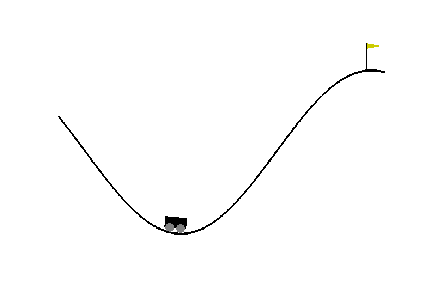
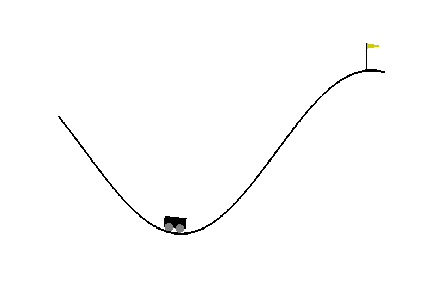
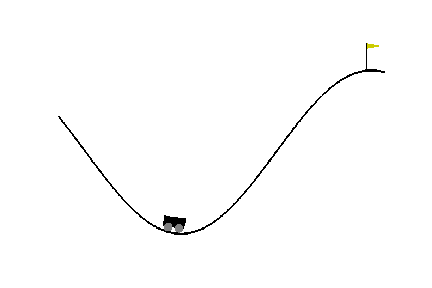
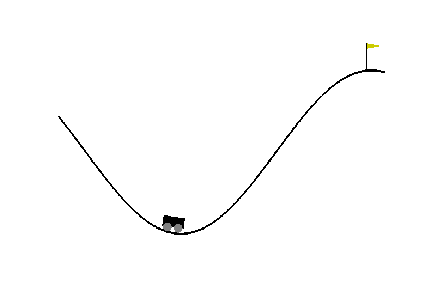
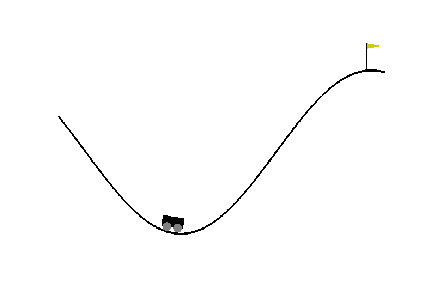
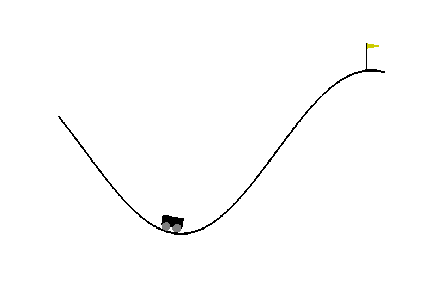
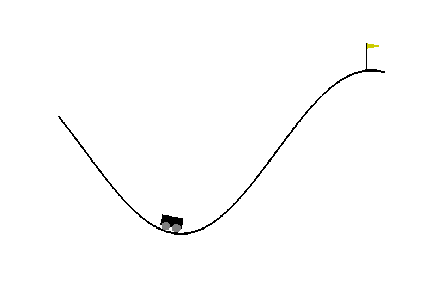
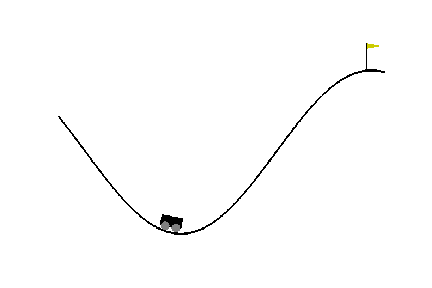
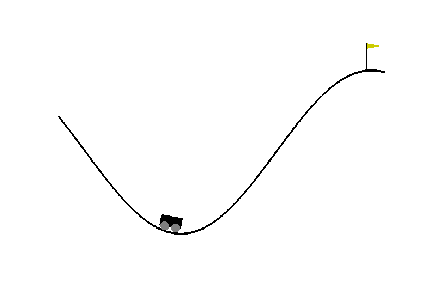
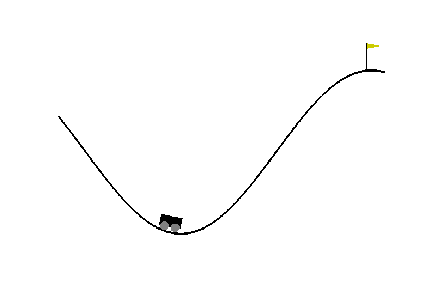
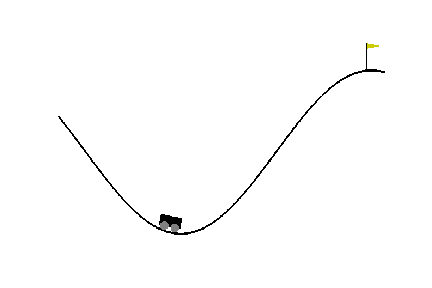
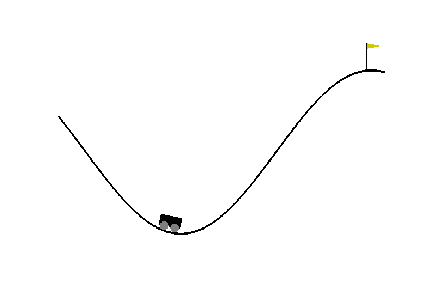
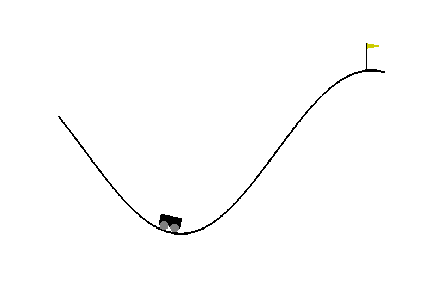
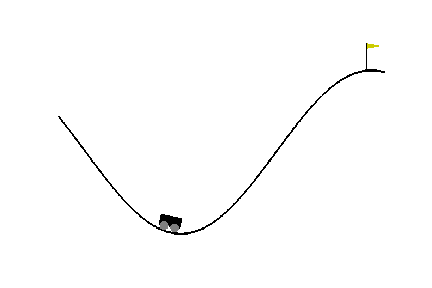
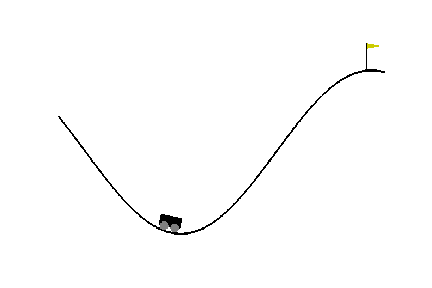
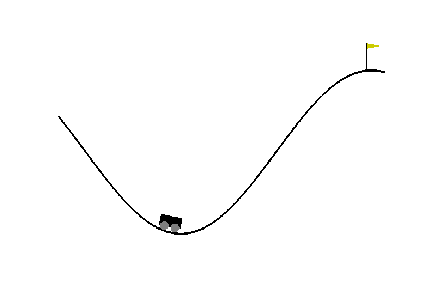
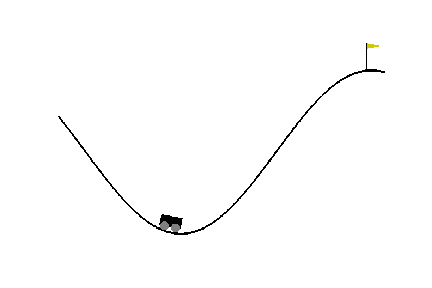
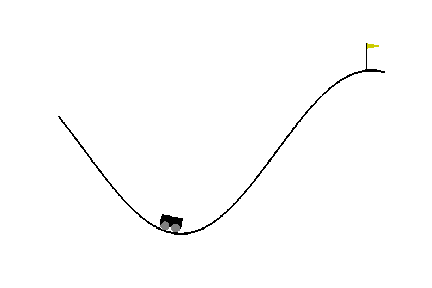
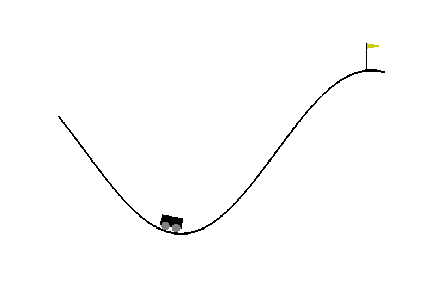
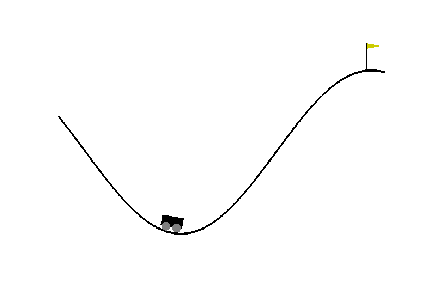
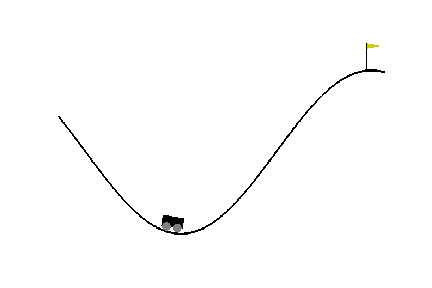
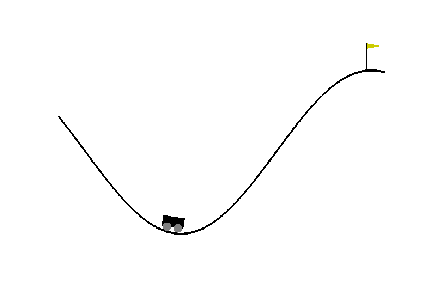
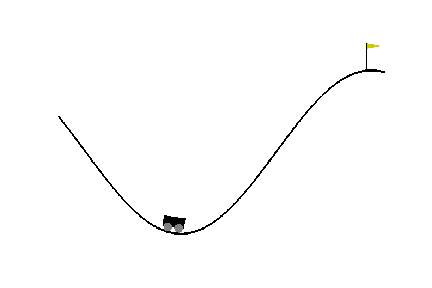
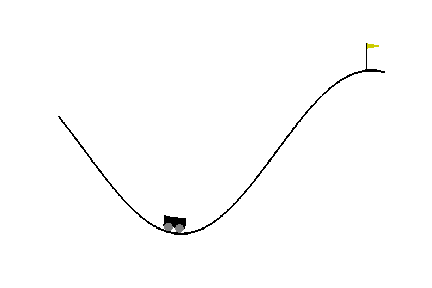
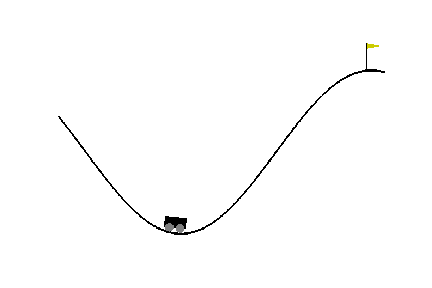
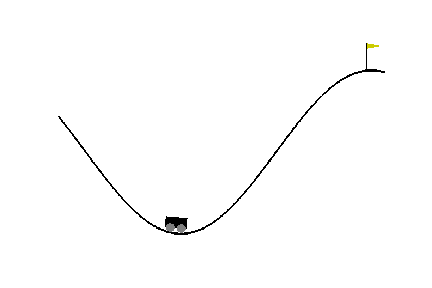
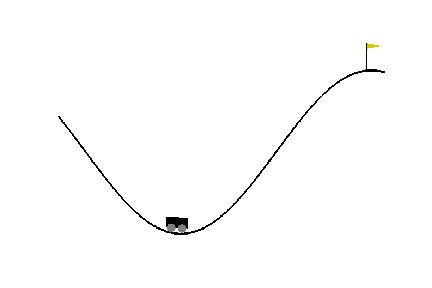
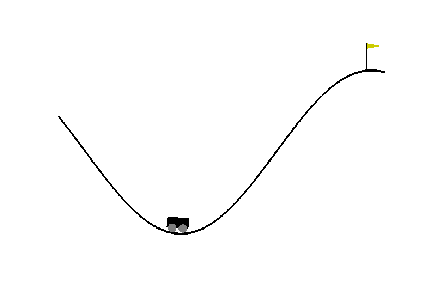
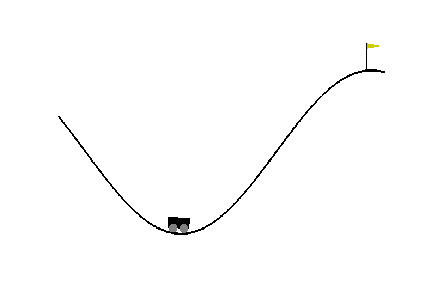
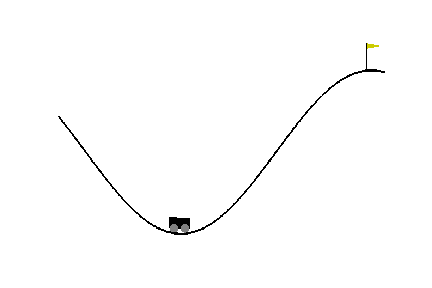
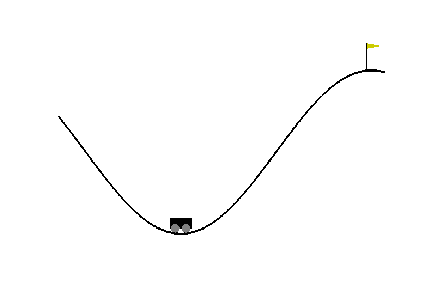
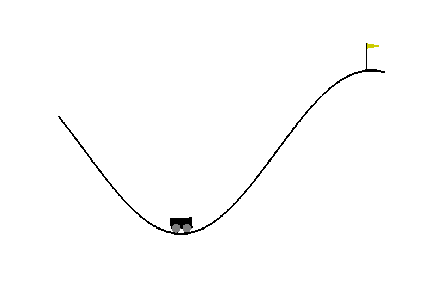
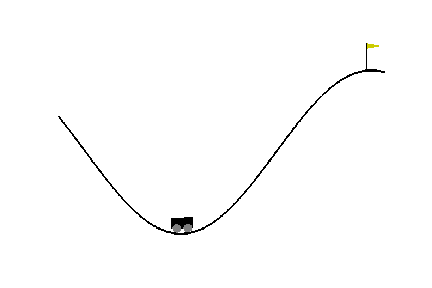
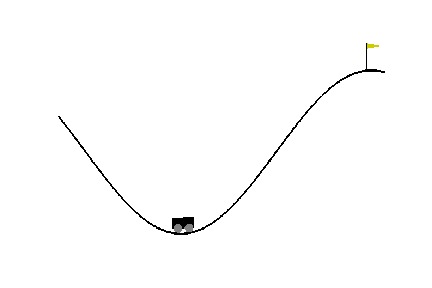
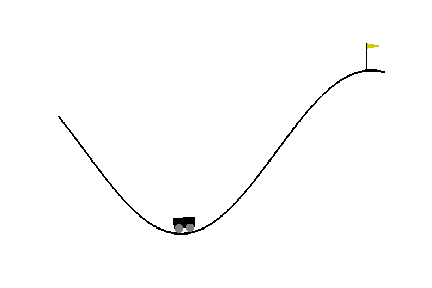
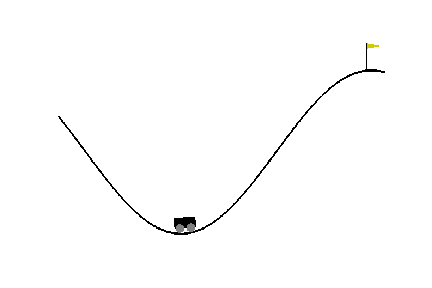
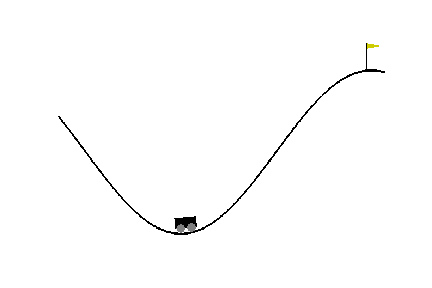
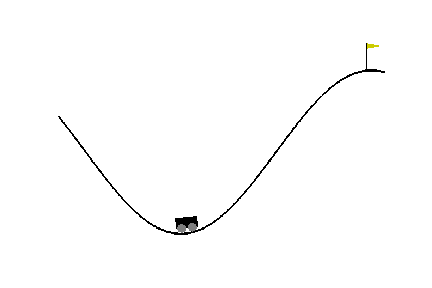
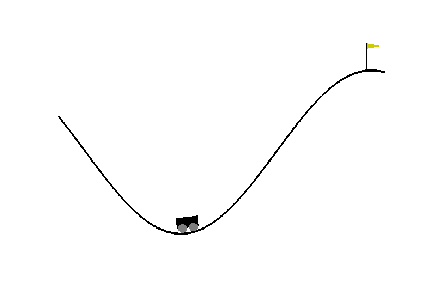
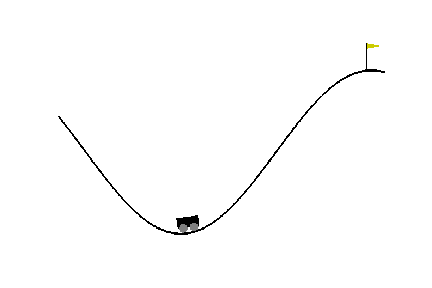
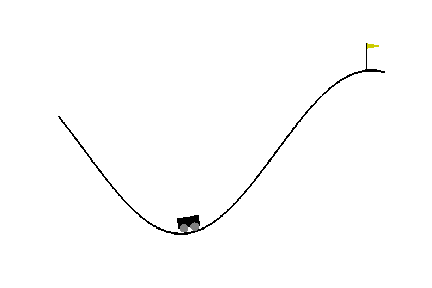
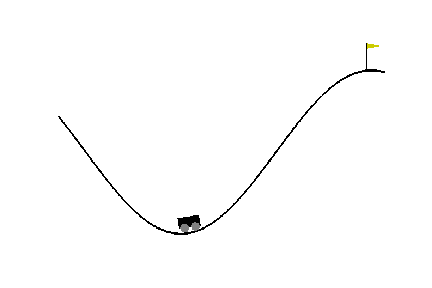
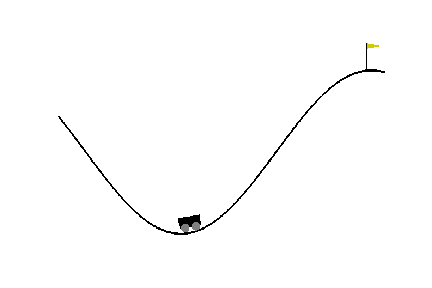
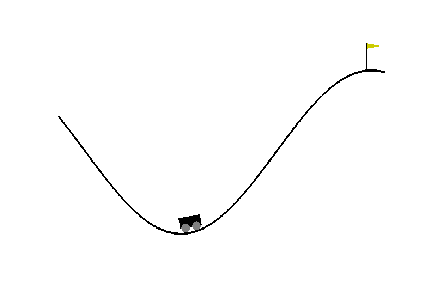
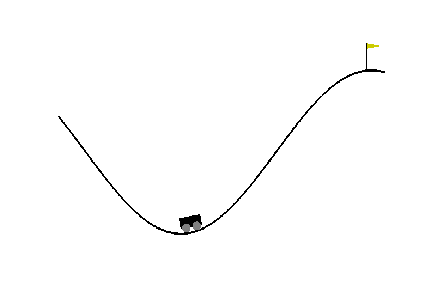
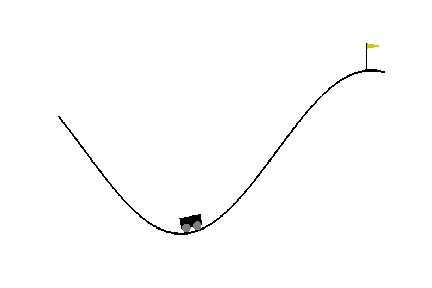
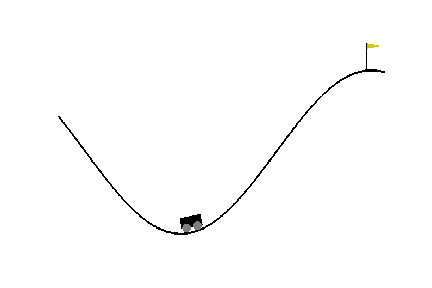
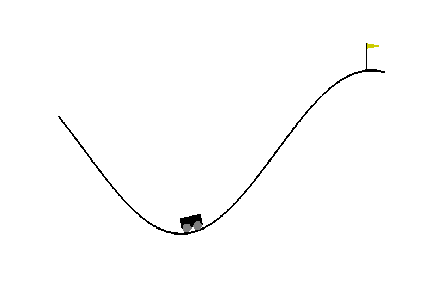
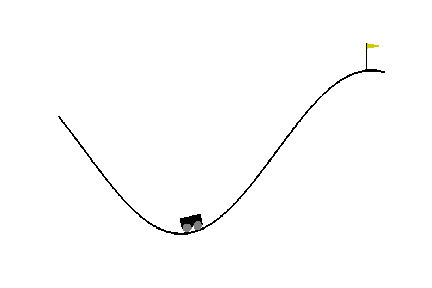
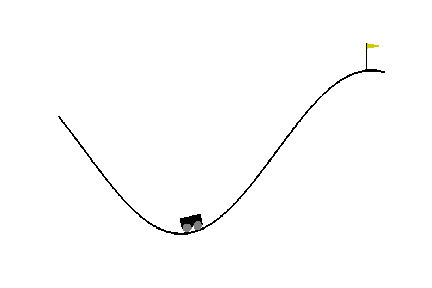
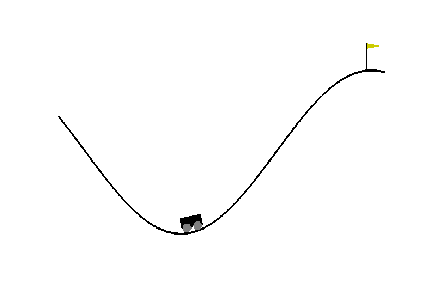
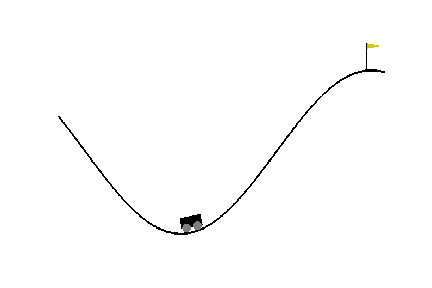
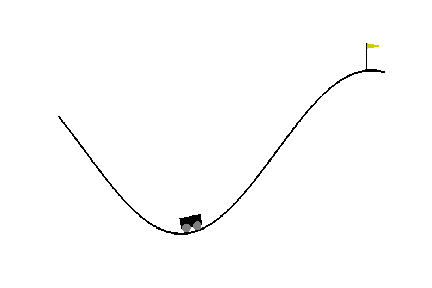
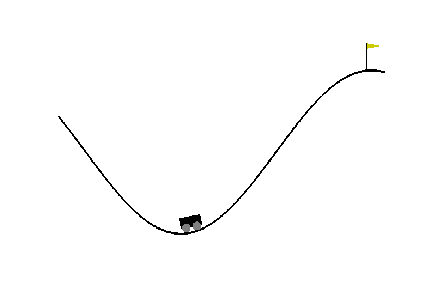
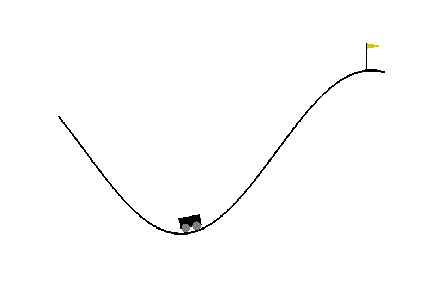
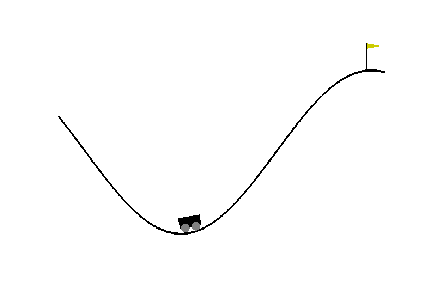
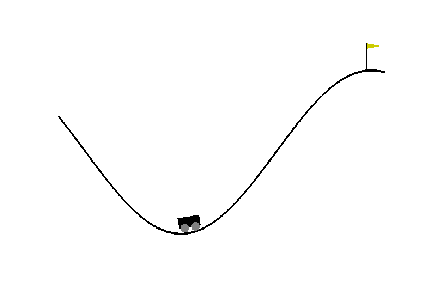
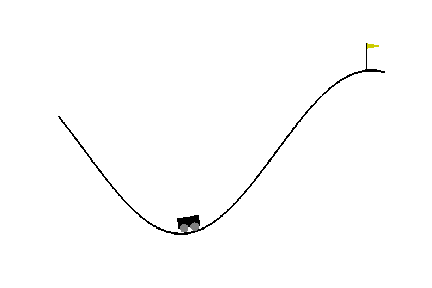
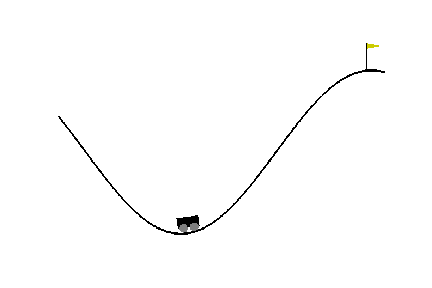
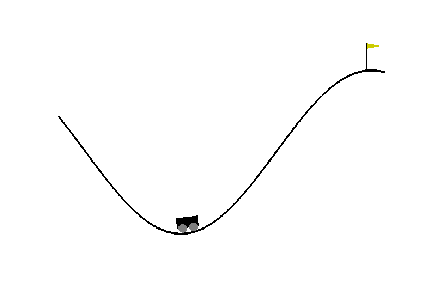
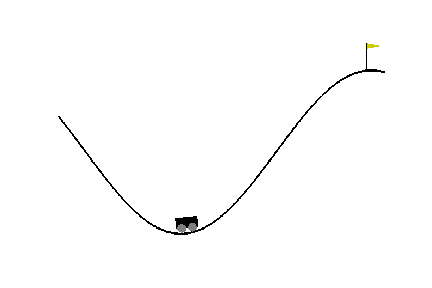
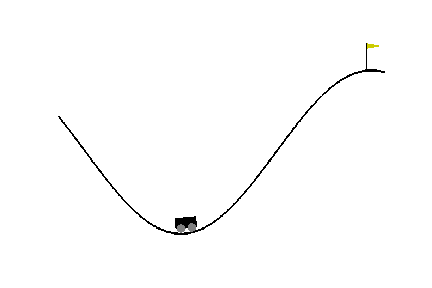
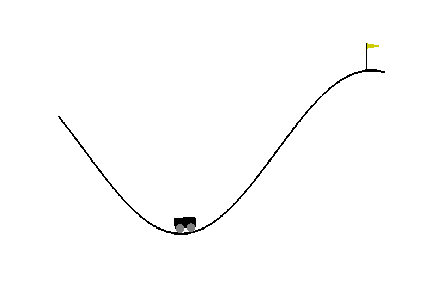
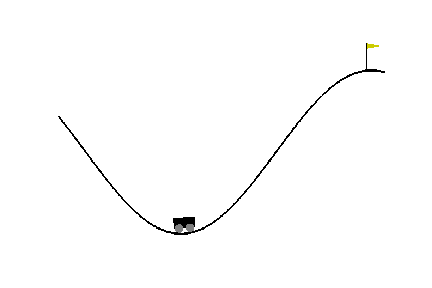
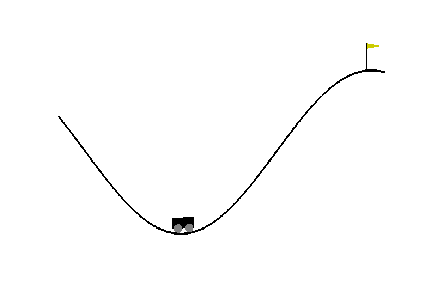
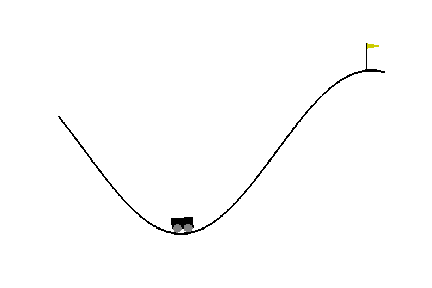
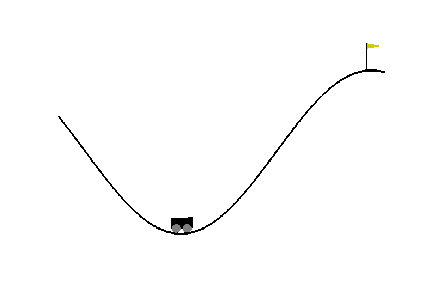
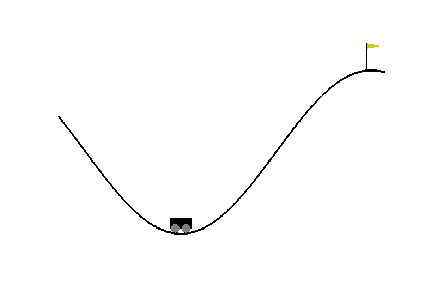
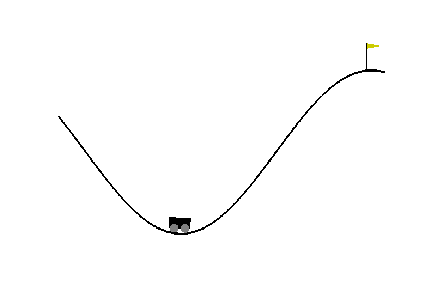
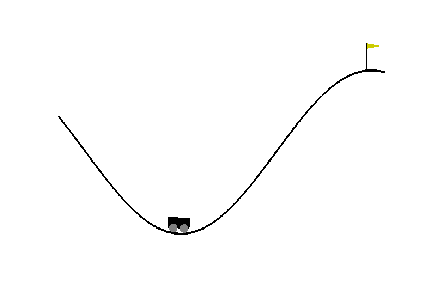
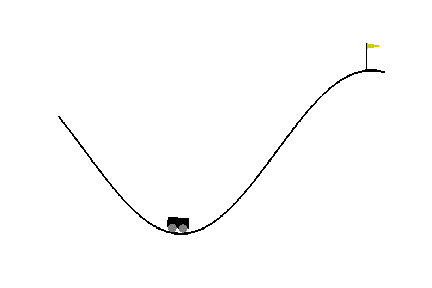
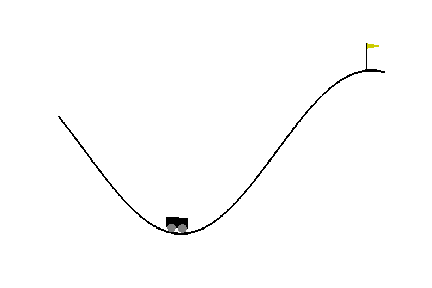
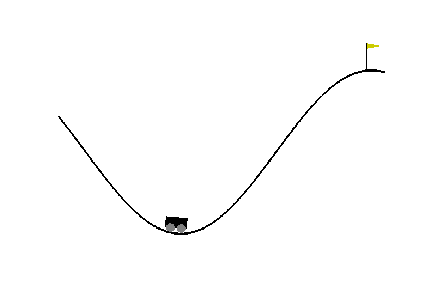
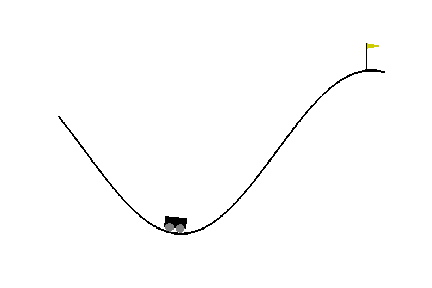
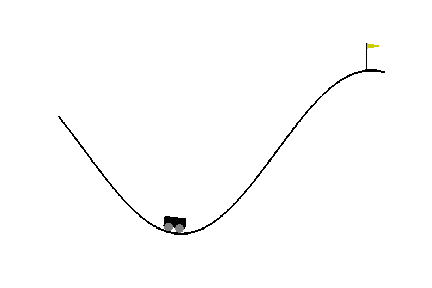
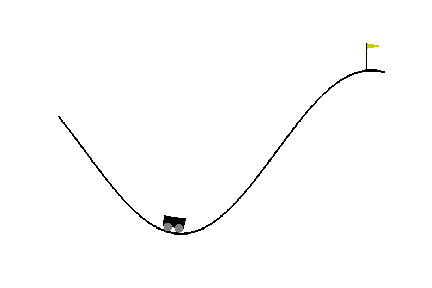
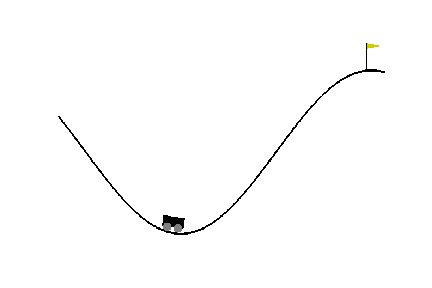
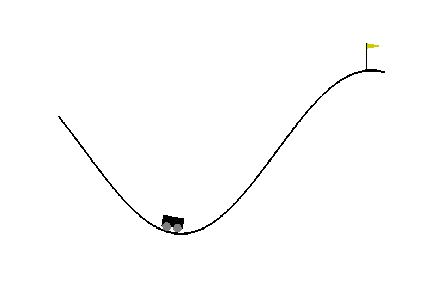
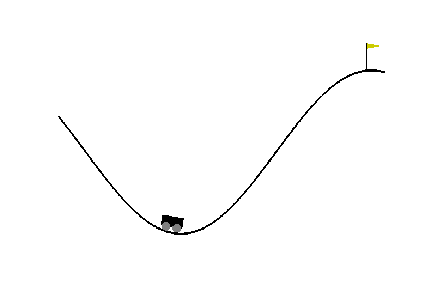
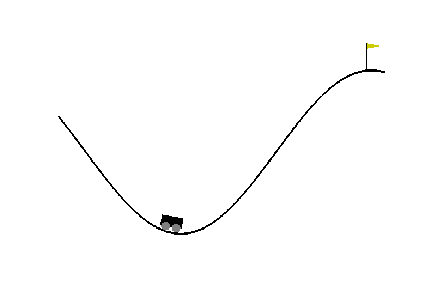
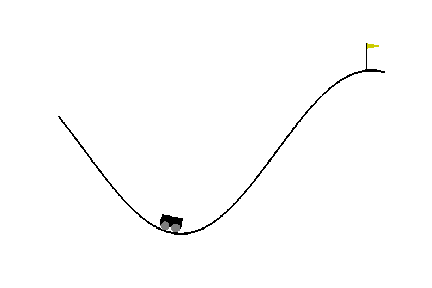
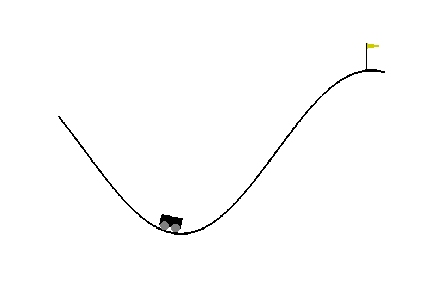
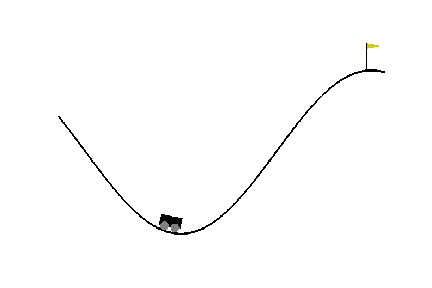
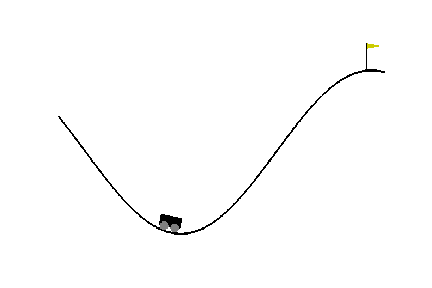
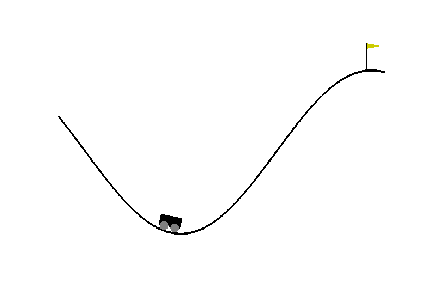
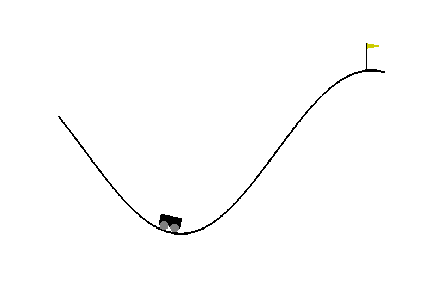
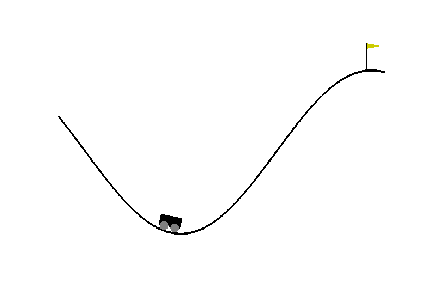
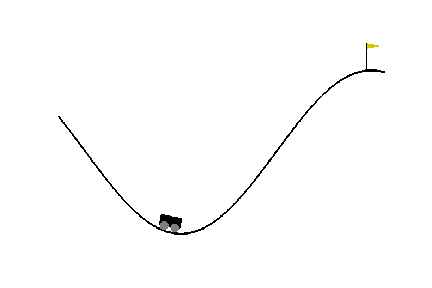
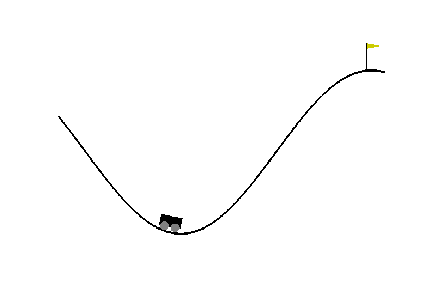
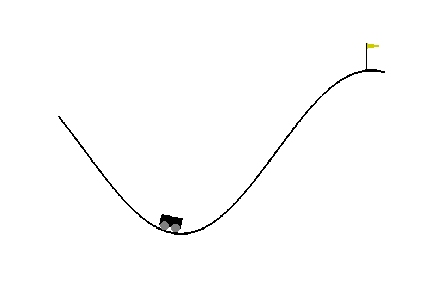
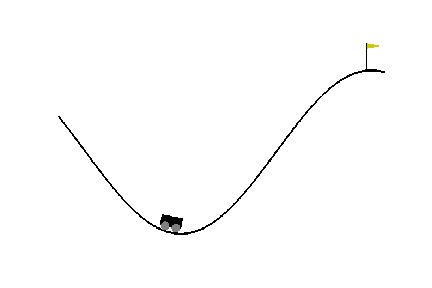
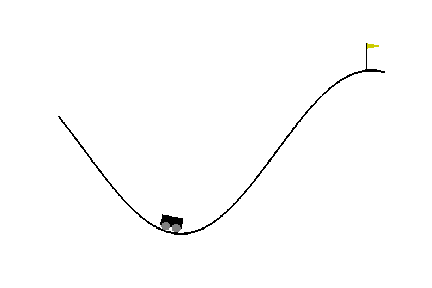
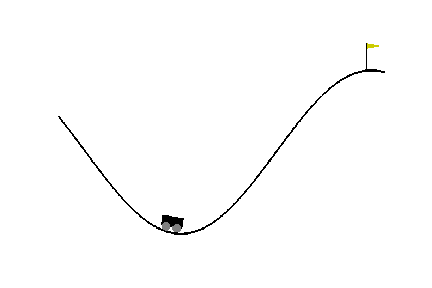
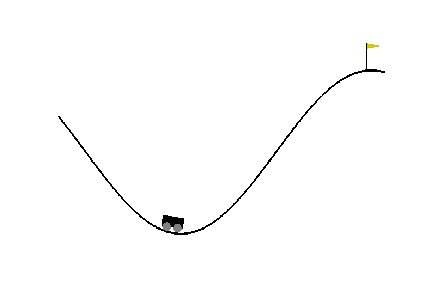
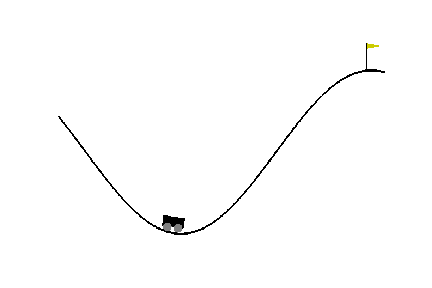
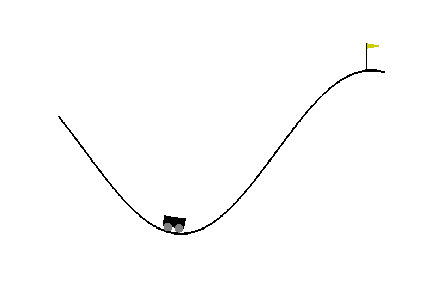
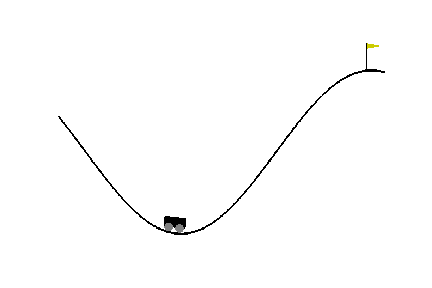
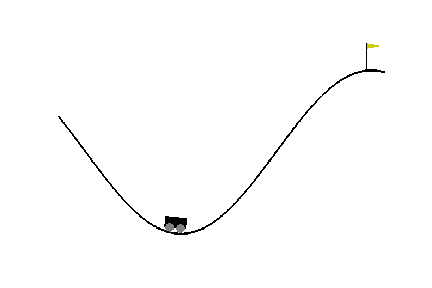
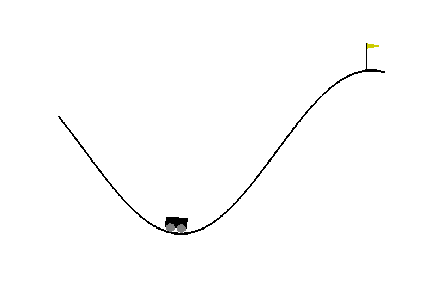
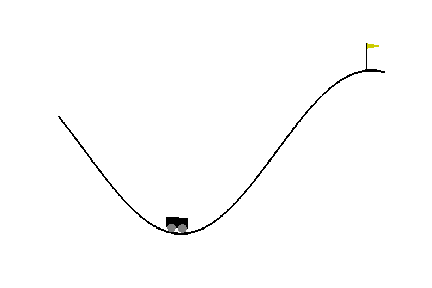
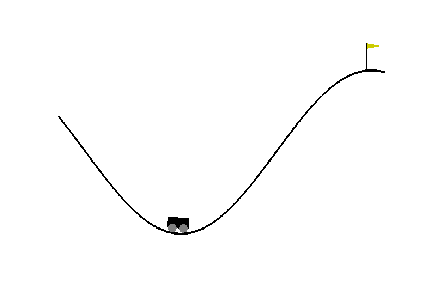
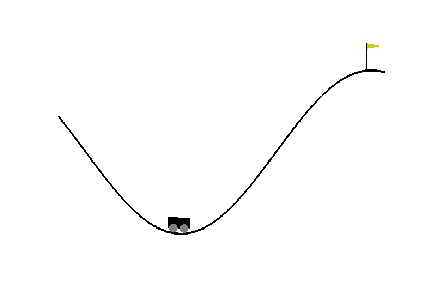
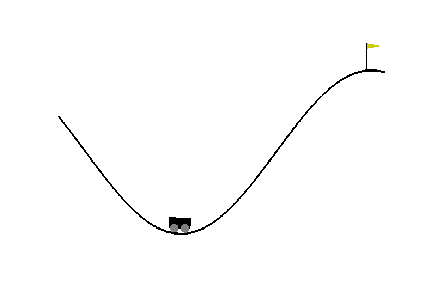
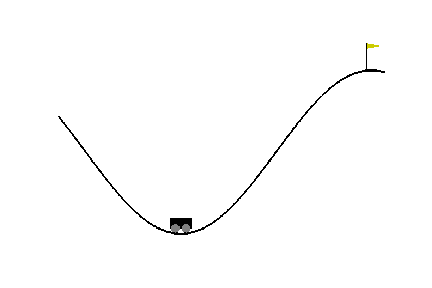
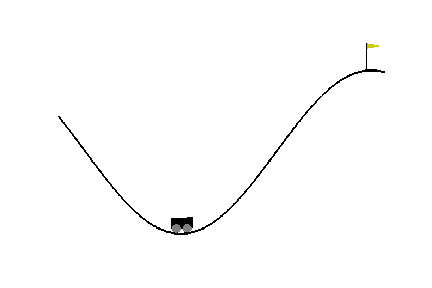
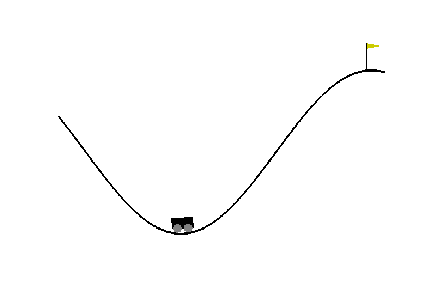
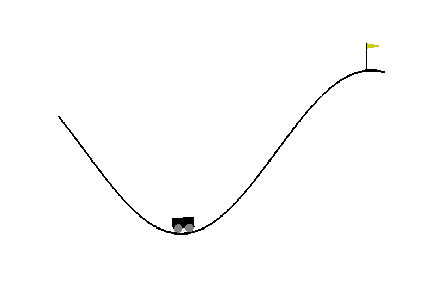
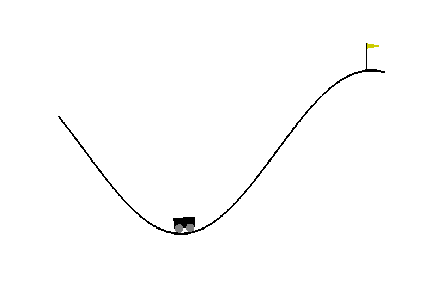
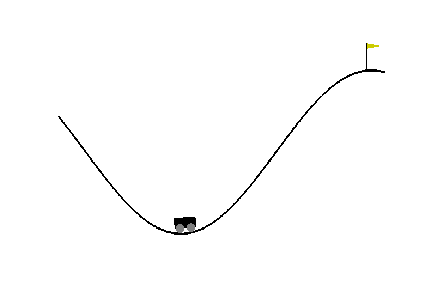
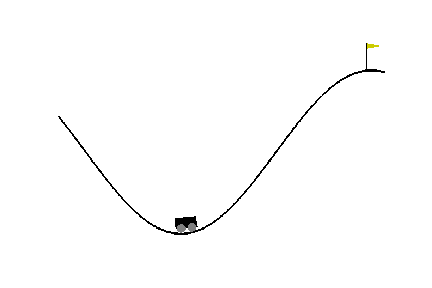
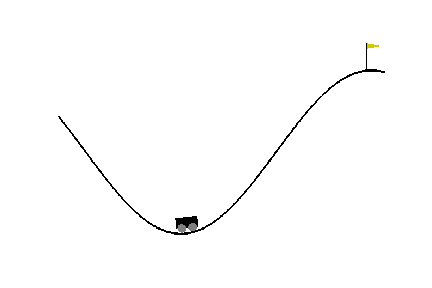
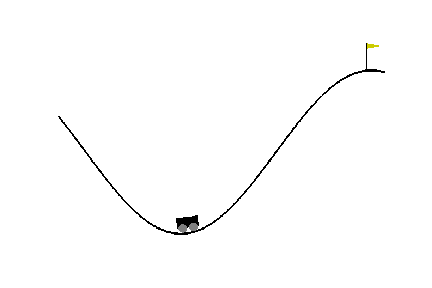
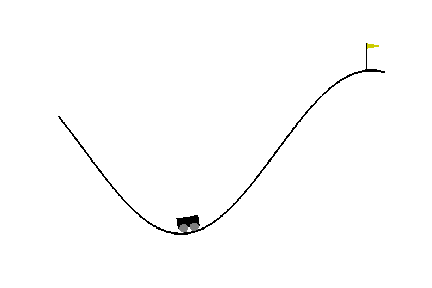
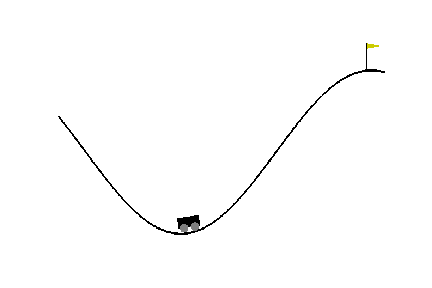
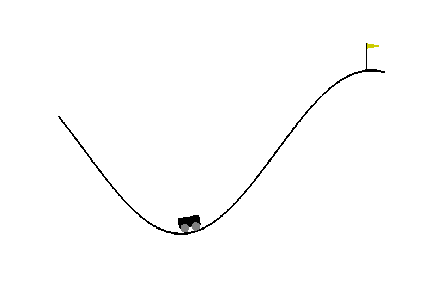
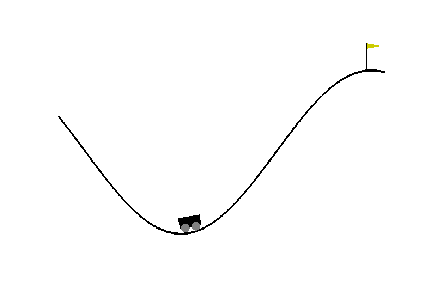
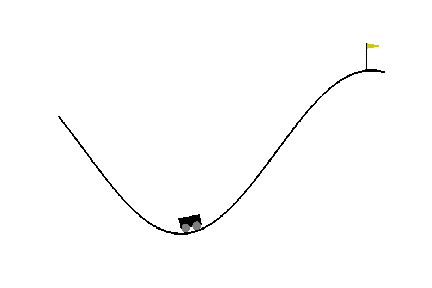
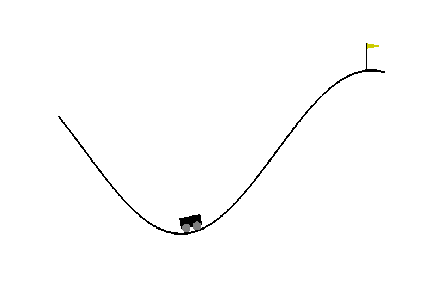
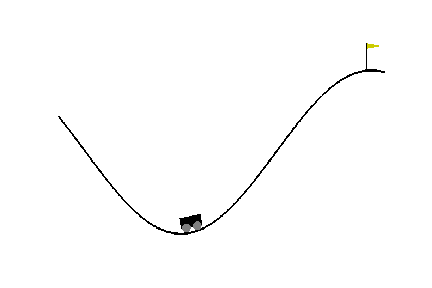
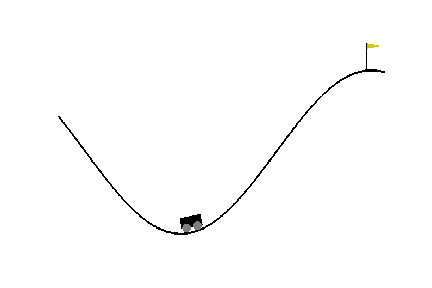
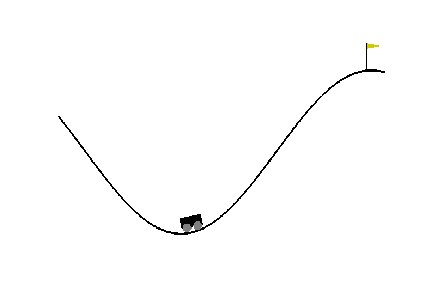
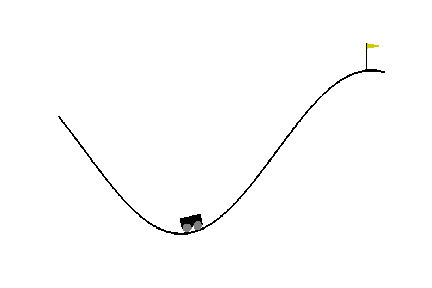
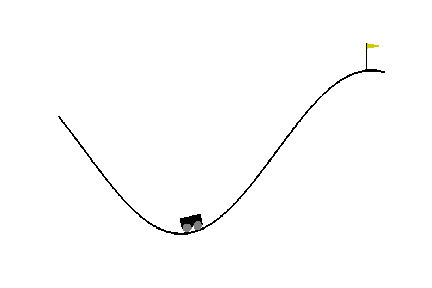
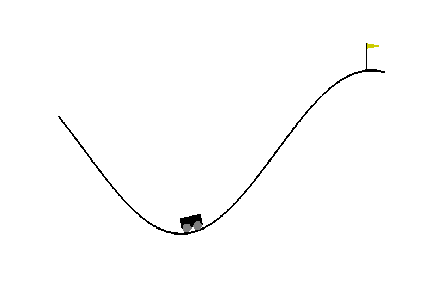
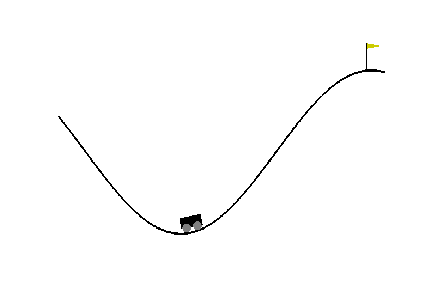
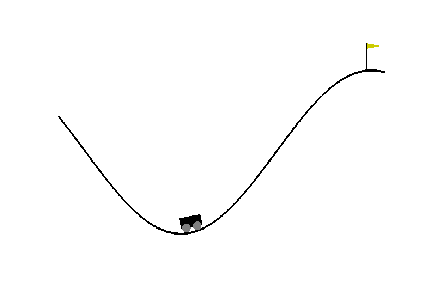
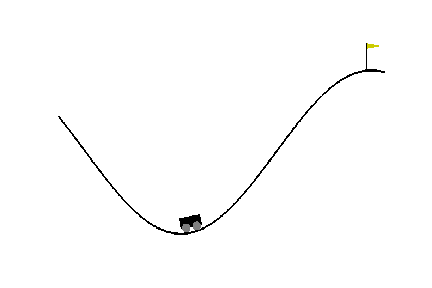
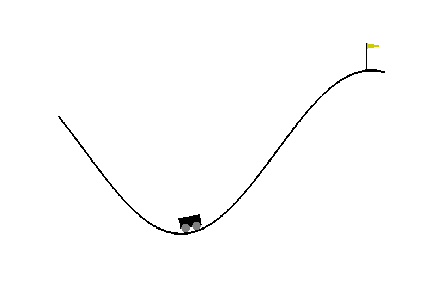
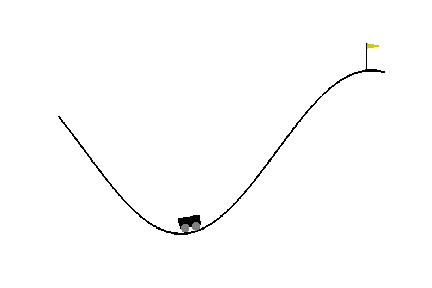
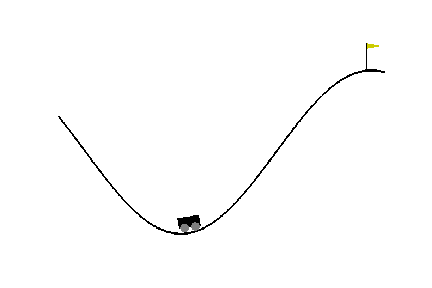
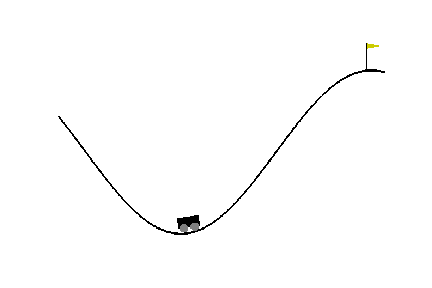
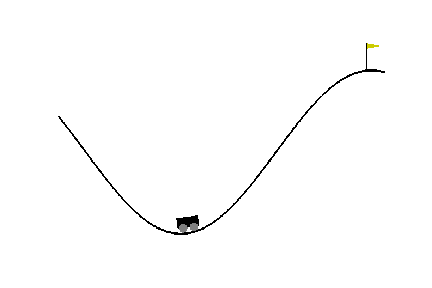
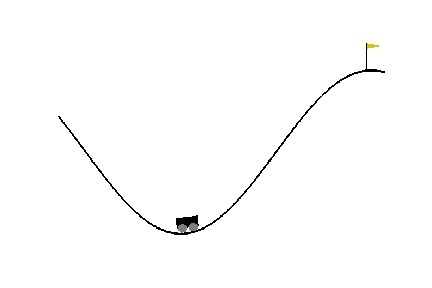
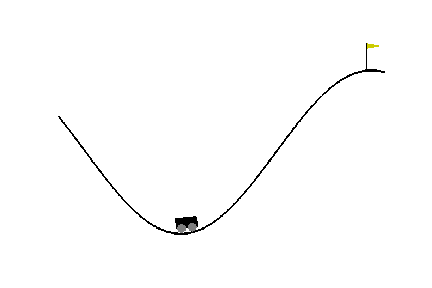
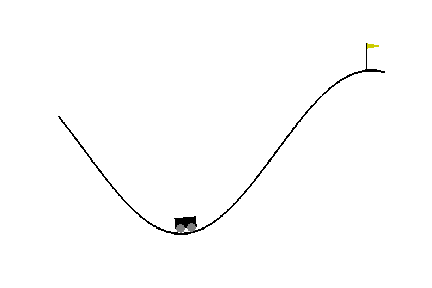
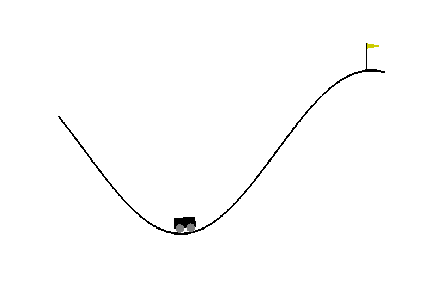
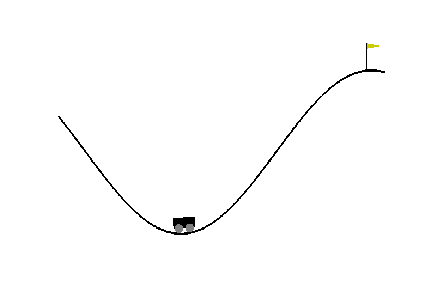
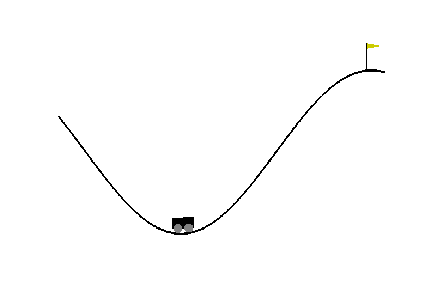
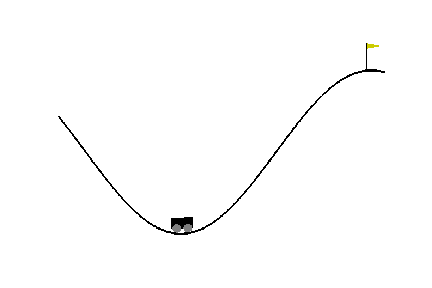
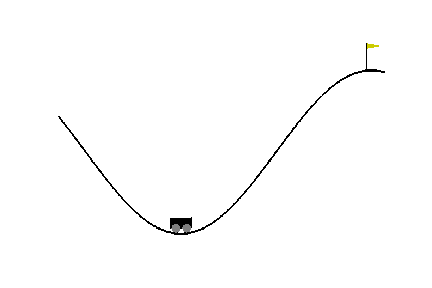

In [7]:
observation = env.reset()
obs = np.expand_dims(observation, axis=0)
state = np.stack((obs, obs), axis=1)
done = False
tot_reward =reward = 0.0
step = -1
frames = []
while not done:
    step += 1
    frames.append(env.render(mode = 'rgb_array'))
    Q = predict(state,layer1,layer2)
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action)
    obs = np.expand_dims(observation, axis=0)
    state = np.append(np.expand_dims(obs, axis=0), state[:, :1, :], axis=1)
    tot_reward += reward
print('Game ended! Total reward: %.6f' % tot_reward)

env.render(close=True)
display_frames_as_gif(frames)